*Imports needed*

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress
import warnings
from typing import List, Optional, Tuple
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import norm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import Image


*Table function to reproduce outputs.*



In [17]:
from IPython.display import display, HTML

def show_table(df: pd.DataFrame, max_height='400px', decimals: int = 2) -> None:
    """
    Display table with HTML help.
    
    Parameters:
        df: The DataFrame to display.
        max_height: The maximum height of the scrollable table (e.g., '400px').
        decimals: Number of decimal places to show in float values.
    """
    float_fmt = f"%.{decimals}f"
    html = (
        df.to_html(border=0, float_format=float_fmt)
        .replace('table border="0"', 'table style="width:100%; border-collapse:collapse;"')
    )
    scroll_box = f'''
    <div style="max-height:{max_height}; overflow:auto; border:1px solid #ccc; padding:10px;">
        {html}
    </div>
    '''
    display(HTML(scroll_box))


*The box below contains the information needed for the program to run and retrieve its analysis.*

__*We'll analyze a portfolio made of 5 stocks: Apple (AAPL), Tesla (TSLA), Walmart (WMT), GE Aerospace (GE), Amazon (AMZN), DB (Deutsche Bank AG) with a total initial investment of 10k.*__

In [18]:
"""Porfolio in Analysis:"""

stocks = ['AAPL','TSLA','WMT','GE','AMZN','DB']
amount_invested = [2000,2000,1500,2000,2000,1500]
start_date = '2020-01-01'
end_date = '2025-04-01'
market = '^GSPC' # Ticker for S&P 500
confidence_interval = 0.95 #VaR
n_days = 30 #VaR

# Get recent 13-week T-bill yield
rf_ticker = yf.Ticker("^IRX")
rf_data = rf_ticker.history(period="5d")
latest_rf_percent = rf_data['Close'].dropna().iloc[-1]

risk_free_rate = latest_rf_percent / 100  # convert to decimal
#risk_free_rate = 5.3/100

__*Summary of initial information needed:*__

In [19]:
summary_data = pd.DataFrame({
    "Stock Ticker": stocks,
    "Amount Invested (€)": amount_invested
})

portfolio_settings = pd.DataFrame({
    "Parameter": [
        "Start Date", 
        "End Date", 
        "Market Benchmark", 
        "Confidence Interval (VaR)", 
        "VaR Horizon (Days)", 
        "Risk-Free Rate"
    ],
    "Value": [
        start_date,
        end_date,
        market,
        f"{int(confidence_interval * 100)}%",
        n_days,
        f"{risk_free_rate:.3%}"
    ]
})

def show_input_summary(summary_df, settings_df):
    html1 = summary_df.to_html(index=False, float_format="%.2f")
    html2 = settings_df.to_html(index=False)

    styled_html = f"""
    <div style="background-color:#ffffff; padding: 15px; border-radius: 8px; color:#222;">
        <h3 style='color:#222;'>📋 <u>Portfolio Composition</u></h3>
        {html1}
        <br>
        <h3 style='color:#222;'>⚙️ <u>Analysis Settings</u></h3>
        {html2}
    </div>
    """

    display(HTML(styled_html))

show_input_summary(summary_data, portfolio_settings)


Stock Ticker,Amount Invested (€)
AAPL,2000
TSLA,2000
WMT,1500
GE,2000
AMZN,2000
DB,1500
Parameter,Value
Start Date,2020-01-01
End Date,2025-04-01
Market Benchmark,^GSPC


---//---

*We will start by gathering the data for the stocks through Yahoo Finance. For simplicity it takes __Close Prices__.*

In [20]:
def download_data(stocks, start, end) -> pd.DataFrame:
        """
        Download and cache close prices for the specified stocks.
        Returns:
            DataFrame of closing prices.
        """
        
        stock_data= {}

        for stock in stocks:
            ticker = yf.Ticker(stock)
            stock_data[stock] = ticker.history(start=start, end=end)['Close']
    
        return pd.DataFrame(stock_data)

if __name__ == '__main__':

    stocks_prices = download_data(stocks,start_date,end_date)
    show_table(stocks_prices)


,AAPL,TSLA,WMT,GE,AMZN,DB
Date,,,,,,
2020-01-02 00:00:00-05:00,72.54,28.68,36.51,57.90,94.90,7.47
2020-01-03 00:00:00-05:00,71.83,29.53,36.19,58.09,93.75,7.28
2020-01-06 00:00:00-05:00,72.41,30.10,36.11,58.92,95.14,7.23
2020-01-07 00:00:00-05:00,72.07,31.27,35.78,58.48,95.34,7.40
2020-01-08 00:00:00-05:00,73.22,32.81,35.65,57.95,94.60,7.69
2020-01-09 00:00:00-05:00,74.78,32.09,36.02,57.80,95.05,7.72
2020-01-10 00:00:00-05:00,74.95,31.88,35.72,56.64,94.16,7.64
2020-01-13 00:00:00-05:00,76.55,34.99,35.57,58.82,94.57,7.61
2020-01-14 00:00:00-05:00,75.52,35.86,35.66,58.38,93.47,7.70


*This next box will reproduce in graphs the prices of the different stocks.*

*In the first graph we see the absolute prices and its variations throught the determined period and in the second we can have it normalized.*

*To analyse I usually refer to the second graph and I choose the "Log Scale" in the Y axes as the Linear Scale is not very good when dealing with stocks whose variations were too high when compared to the remaining in the portfolio.*

In [21]:
def show_data(df: pd.DataFrame) -> None:
    """
    Plot the historical closing prices.
    """
    fig = go.Figure()

    for ticker in df.columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[ticker],
            mode='lines',
            name=ticker
        ))

    fig.update_layout(
        title="Historical Close Prices",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_white",
        hovermode="x unified",
        width=1000,
        height=500,
        legend_title_text="Stocks"
    )

    fig.show()
    fig.write_image("historical_prices.png")

def show_data_normalized(df: pd.DataFrame) -> None:
    """
    Plot normalized historical closing prices.
    """
    normalized_df = df.apply(lambda x: x / x.dropna().iloc[0])

    fig = go.Figure()

    for ticker in normalized_df.columns:
        fig.add_trace(go.Scatter(
            x=normalized_df.index,
            y=normalized_df[ticker],
            mode='lines',
            name=ticker
        ))

    fig.update_layout(
        title="Normalized Price Performance (Start = 1)",
        xaxis_title="Date",
        yaxis_title="Relative Performance",
        yaxis_type="linear",  # default view
        template="plotly_white",
        hovermode="x unified",
        width=1000,
        height=500,
        legend_title_text="Stocks",
        updatemenus=[
            {
                "buttons": [
                    {
                        "label": "Linear Scale",
                        "method": "relayout",
                        "args": [{"yaxis.type": "linear"}]
                    },
                    {
                        "label": "Log Scale",
                        "method": "relayout",
                        "args": [{"yaxis.type": "log"}]
                    }
                ],
                "direction": "right",
                "pad": {"r": 10, "t": 10},
                "showactive": True,
                "type": "buttons",
                "x": 0.0,
                "xanchor": "left",
                "y": 1.15,
                "yanchor": "top"
            }
        ]
    )

    fig.show()
    fig.write_image("normalized_prices.png")


show_data(stocks_prices)
show_data_normalized(stocks_prices)

_(The plots in this notebook will not be displayed directly on GitHub but are generated as PNG files.
To see the graphs, download this repository and run the notebook locally. There you'll see the graphs and be able to interact with them)_

On the graph above we can already start taking some relevant conclusion for your analysis.

First, by looking at the second graph, we can verify that Tesla stock outperformed by far the remaining stocks in the portfolio, with Amazon being the one yielding the lowest return during the analyzed period.

Secondly, for a large period of our analysis, GE Aerospace was not performing well, having recovered from October 2022 onwards.

In terms of volatility we can see that the stock with most variations is TSLA (we will confirm this later but by looking at the picture we can already have a glance).

In terms of stocks moving with the market (we can also put here the S&P500 to compare )

Apple througout this period stands out as a stock with a considerable return - benefiting from the tech boom - but also with a consistent performance and therefore I dont expect it to have a high volatility (=> expect low variance).

To continue analyze we will now look at the returns so we can look at the variance and stocks performance in a more in deph way. 

In [22]:
def calculate_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Compute daily log returns from a price DataFrame.
    Returns:
        DataFrame of daily log returns.
    """
    log_ret = np.log(prices / prices.shift(1))
    return log_ret.dropna()


stocks_returns = calculate_returns(stocks_prices)
show_table(stocks_returns)

,AAPL,TSLA,WMT,GE,AMZN,DB
Date,,,,,,
2020-01-03 00:00:00-05:00,-0.01,0.03,-0.01,0.00,-0.01,-0.03
2020-01-06 00:00:00-05:00,0.01,0.02,-0.00,0.01,0.01,-0.01
2020-01-07 00:00:00-05:00,-0.00,0.04,-0.01,-0.01,0.00,0.02
2020-01-08 00:00:00-05:00,0.02,0.05,-0.00,-0.01,-0.01,0.04
2020-01-09 00:00:00-05:00,0.02,-0.02,0.01,-0.00,0.00,0.00
2020-01-10 00:00:00-05:00,0.00,-0.01,-0.01,-0.02,-0.01,-0.01
2020-01-13 00:00:00-05:00,0.02,0.09,-0.00,0.04,0.00,-0.00
2020-01-14 00:00:00-05:00,-0.01,0.02,0.00,-0.01,-0.01,0.01
2020-01-15 00:00:00-05:00,-0.00,-0.04,-0.01,-0.01,-0.00,-0.02


Below we can see the average of the returns annualized => what we expect that each stocks yields per year according to this past performance (of course gathering insights for future performance from past performance is not of guaranteed performance but we can take already take insights from it).

In [23]:
def get_stock_annualized_returns(returns: pd.DataFrame, num_trading_days: int = 252) -> None:
    """
    Display annualized mean and median returns for each stock.

    Parameters:
        returns: DataFrame of daily returns (e.g., log returns).
        num_trading_days: Number of trading days per year (default: 252).
    """
    ann_mean = returns.mean() * num_trading_days
    ann_median = returns.median() * num_trading_days

    summary = pd.DataFrame({
        "Annualized Mean Return": ann_mean,
        "Annualized Median Return": ann_median
    })

    display(
        summary.style
            .format("{:.2%}")
            .set_properties(**{'text-align': 'center'})
            .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
    )

# Example usage
get_stock_annualized_returns(stocks_returns)


,Annualized Mean Return,Annualized Median Return
AAPL,21.37%,29.14%
TSLA,42.12%,41.77%
WMT,16.70%,20.37%
GE,23.68%,24.65%
AMZN,13.31%,16.33%
DB,21.67%,23.85%


*In these histograms we can see the distributions of the returns across the pre-determined period of time.*

*From here we can already check which stocks are more volatile (Wide and Shallow will tend to be more volatile but also paying attention to outliers)*

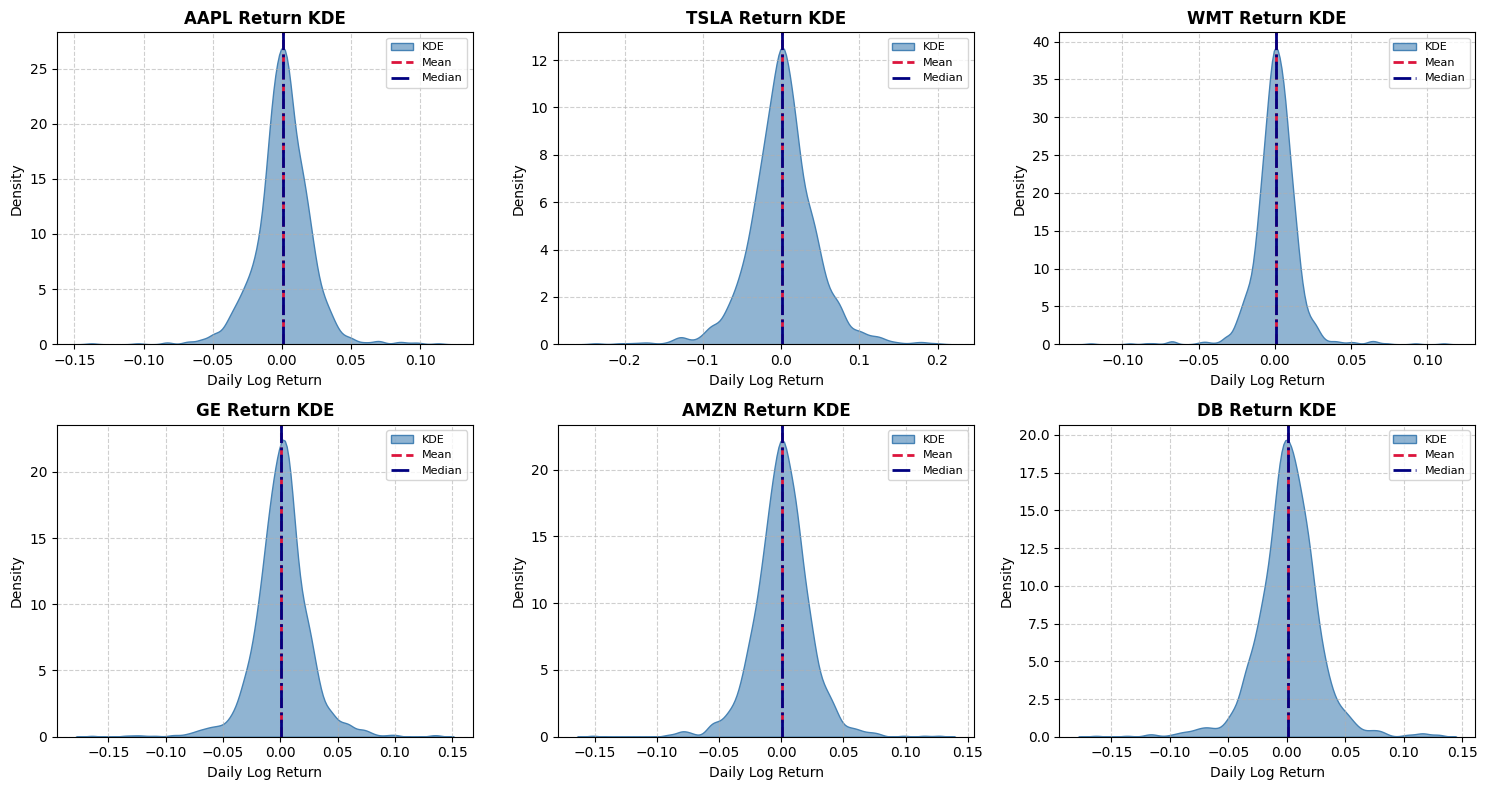

In [24]:
def show_return_distribution_plotly(rets: pd.DataFrame,bins: int = 50) -> None:
    """
    Plot an interactive histogram of daily log returns for each stock,
    with a vertical dashed line at the mean, using Plotly subplots.

    Parameters:
        rets: DataFrame of daily log returns (columns = tickers).
        bins: Number of bins in each histogram.
    """
    stocks = rets.columns.tolist()
    n = len(stocks)
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=stocks,
        horizontal_spacing=0.12,
        vertical_spacing=0.20
    )

    for idx, ticker in enumerate(stocks):
        r = idx // cols + 1
        c = idx % cols + 1

        fig.add_trace(
            go.Histogram(
                x=rets[ticker],
                nbinsx=bins,
                marker_color='steelblue',
                opacity=0.75,
                showlegend=False
            ),
            row=r, col=c
        )
        mean = rets[ticker].mean()
        fig.add_vline(
            x=mean,
            line=dict(color='crimson', dash='dash', width=2),
            row=r, col=c
        )

    # remove empty subplots titles/grids
    total_plots = rows * cols
    for empty_idx in range(n, total_plots):
        er = empty_idx // cols + 1
        ec = empty_idx % cols + 1
        ann_index = empty_idx
        if ann_index < len(fig.layout.annotations):
            fig.layout.annotations[ann_index].update(text='')
        fig['layout'][f'xaxis{empty_idx+1}'].update(showgrid=False, zeroline=False)
        fig['layout'][f'yaxis{empty_idx+1}'].update(showgrid=False, zeroline=False)

    fig.update_layout(
        title_text="Distribution of Daily Log Returns per Stock",
        title_y=0.95,
        template="plotly_white",
        height=rows * 300,
        width=cols * 400,
        bargap=0.1,
        margin=dict(t=100, b=50, l=50, r=50)
    )
    fig.update_xaxes(title_text="Daily Log Return")
    fig.update_yaxes(title_text="Count")
    fig.show()


def show_return_kde(
    rets: pd.DataFrame,
    bandwidth: Optional[float] = None
) -> None:
    """
    Plot a KDE (kernel density estimate) of daily log returns for each stock
    in individual subplots, with lines for mean and median.

    Parameters:
        rets: DataFrame of daily log returns (columns = tickers).
        bandwidth: KDE bandwidth adjustment factor (bw_adjust in seaborn).
    """
    stocks = rets.columns.tolist()
    n = len(stocks)
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)

    for idx, ticker in enumerate(stocks):
        ax = axes[idx]
        data = rets[ticker]

        sns.kdeplot(
            data,
            ax=ax,
            fill=True,
            bw_adjust=bandwidth or 1,
            alpha=0.6,
            color='steelblue',
            label='KDE'
        )

        mean = data.mean()
        median = data.median()
        ax.axvline(mean, color='crimson', linestyle='--', linewidth=2, label='Mean')
        ax.axvline(median, color='navy', linestyle='-.', linewidth=2, label='Median')

        ax.set_title(f'{ticker} Return KDE', fontsize=12, fontweight='bold')
        ax.set_xlabel('Daily Log Return', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.6)

    # remove unused axes
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

show_return_kde(stocks_returns, bandwidth=0.8)
show_return_distribution_plotly(stocks_returns, bins=60)

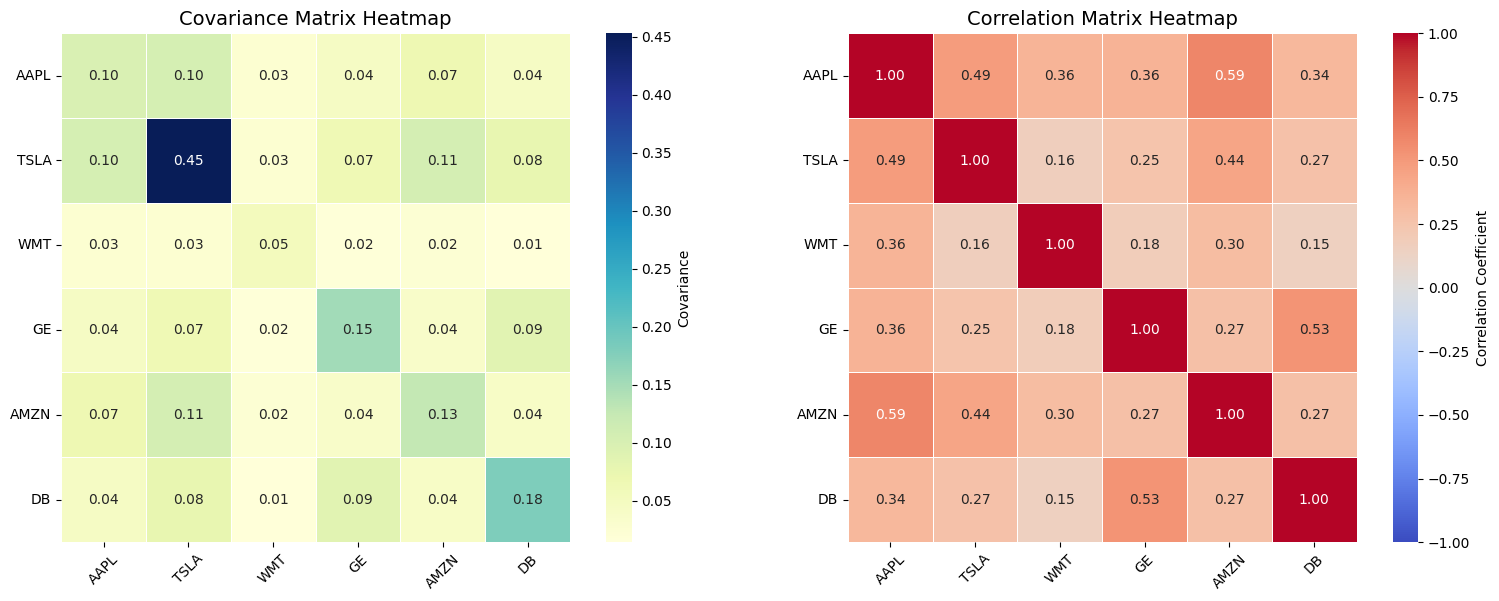

In [25]:
def get_annualized_cov_corr(returns: pd.DataFrame, num_trading_days: int = 252) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    ann_cov = returns.cov() * num_trading_days
    ann_corr = returns.corr()

    # Plotting heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Covariance heatmap
    sns.heatmap(
        ann_cov,
        ax=axes[0],
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"label": "Covariance"}
    )
    axes[0].set_title("Covariance Matrix Heatmap", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)

    # Correlation heatmap
    sns.heatmap(
        ann_corr,
        ax=axes[1],
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        vmin=-1,
        vmax=1,
        cbar_kws={"label": "Correlation Coefficient"}
    )
    axes[1].set_title("Correlation Matrix Heatmap", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()

get_annualized_cov_corr(stocks_returns)

With the Covariance Matrix, by looking at the diagonal from the top left corner to the bottom right, we can quickly spot and confirm the volatility of Tesla Stock as well as the low volatility of Walmart followed by Apple.

In terms of correlation, the first interesting point is that we dont have any negative value. This tells us that these stocks tend to move in the same direction with Amazon and Apple having the highest correlation and Walmart and Deutsche Bank having the lowest one. 

Note that, lower correlations between stocks mean better diversification benefits, potentially lowering portfolio risk.

---//---

Below we can see a framework that simulates, analyzes, and optimizes our portfolio based on historical stock return data. It uses random portfolio generation (Monte Carlo), mean-variance analysis, and the Sharpe ratio for optimization, culminating in the visualization of the efficient frontier with the optimal portfolio highlighted:


Optimal Portfolio Weights:
  AAPL: 10.1%
  TSLA: 15.2%
  WMT: 49.9%
  GE: 18.6%
  AMZN: 0.0%
  DB: 6.2%

Expected Return:    22.65%
Expected Volatility:23.15%
Sharpe Ratio:       0.81


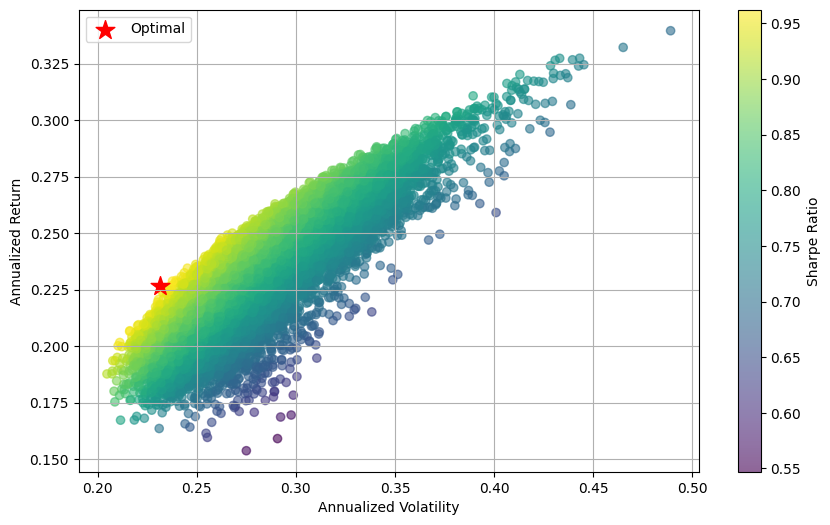

In [26]:
def generate_portfolios(
    returns: np.ndarray,
    num_portfolios: int = 1000,
    seed: Optional[int] = None,
    num_trading_days: int = 252
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate random portfolios.

    Parameters:
        returns: (T × N) array of daily returns.
        num_portfolios: how many random portfolios to generate.
        seed: seed for reproducibility.
        num_trading_days: trading days per year (for annualization).

    Returns:
        weights_array: (num_portfolios × N) array of weights.
        means:  array of annualized returns for each portfolio.
        risks:  array of annualized volatilities for each portfolio.
    """
    if seed is not None:
        np.random.seed(seed)

    N = returns.shape[1]
    cov = np.cov(returns, rowvar=False) * num_trading_days
    mu = returns.mean(axis=0) * num_trading_days

    weights_list = []
    means = []
    risks = []

    for _ in range(num_portfolios):
        w = np.random.random(N)
        w /= w.sum()
        weights_list.append(w)
        port_ret = mu @ w
        port_vol = np.sqrt(w @ cov @ w)
        means.append(port_ret)
        risks.append(port_vol)

    return np.array(weights_list), np.array(means), np.array(risks)

def portfolio_statistics(
    weights: np.ndarray,
    returns: np.ndarray,
    num_trading_days: int = 252,
    risk_free_rate: float = 0.0
) -> np.ndarray:
    """
    Compute [return, volatility, Sharpe] for a given weight.

    Parameters:
        weights: (N,) array of allocations.
        returns: (T × N) array of daily returns.
        num_trading_days: annualization factor.
        risk_free_rate: annual risk-free rate (e.g., 0.01 for 1%).

    Returns:
        array([annual_return, annual_vol, sharpe_ratio])
    """
    mu = returns.mean(axis=0) * num_trading_days
    cov = np.cov(returns, rowvar=False) * num_trading_days

    port_ret = mu @ weights
    port_vol = np.sqrt(weights @ cov @ weights)
    sharpe = (port_ret - risk_free_rate) / port_vol
    return np.array([port_ret, port_vol, sharpe])

def optimize_portfolio(
    returns: np.ndarray,
    num_trading_days: int = 252,
    num_portfolios: int = 1000,
    seed: Optional[int] = None,
    risk_free_rate: float = 0.0
) -> Tuple[object, np.ndarray, np.ndarray, np.ndarray]:
    """
    Find the portfolio that maximizes the Sharpe ratio via random start + SLSQP.

    Returns:
        result: OptimizeResult from scipy
        weights_array, means, risks: full simulation arrays
    """
    W, M, R = generate_portfolios(
        returns,
        num_portfolios=num_portfolios,
        seed=seed,
        num_trading_days=num_trading_days
    )
    x0 = W[0]
    bounds = [(0, 1)] * W.shape[1]
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)

    def neg_sharpe(w):
        return -portfolio_statistics(w, returns, num_trading_days, risk_free_rate)[2]

    result = minimize(
        neg_sharpe,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )
    return result, W, M, R


def print_optimal_portfolio(
    result: object,
    returns: np.ndarray,
    tickers: List[str],
    num_trading_days: int = 252,
    risk_free_rate: float = 0.0
) -> None:
    """
    Print the optimal weights and its performance.
    """
    w_opt = result.x.round(4)
    print("Optimal Portfolio Weights:")
    for t, w in zip(tickers, w_opt):
        print(f"  {t}: {w*100:.1f}%")

    stats = portfolio_statistics(w_opt, returns, num_trading_days, risk_free_rate)
    print(f"\nExpected Return:    {stats[0]:.2%}")
    print(f"Expected Volatility:{stats[1]:.2%}")
    print(f"Sharpe Ratio:       {stats[2]:.2f}")


def plot_efficient_frontier(
    W: np.ndarray,
    M: np.ndarray,
    R: np.ndarray,
    result,
    returns: np.ndarray,
    num_trading_days: int = 252,
    risk_free_rate: float = 0.0
) -> None:
    """
    Plot the simulated portfolios and highlight the optimal one.

    Parameters:
        W: (P × N) array of portfolio weights.
        M: (P,) array of annualized returns from generate_portfolios.
        R: (P,) array of annualized volatilities from generate_portfolios.
        result: OptimizeResult from optimize_portfolio.
        returns: (T × N) array of daily returns used for statistics.
        num_trading_days: trading days per year.
        risk_free_rate: annual risk-free rate (e.g., 0.01 for 1%).
    """
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(R, M, c=M / R, cmap='viridis', alpha=0.6)
    plt.colorbar(sc, label='Sharpe Ratio')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.grid(True)

    ret_opt, vol_opt, _ = portfolio_statistics(
        result.x, returns, num_trading_days, risk_free_rate
    )
    plt.scatter(vol_opt, ret_opt,
                color='red', s=200, marker='*', label='Optimal')
    plt.legend()
    plt.show()

res, W, M, R = optimize_portfolio(stocks_returns, num_trading_days=252, num_portfolios=20000, seed=1, risk_free_rate = risk_free_rate)

print_optimal_portfolio(res, stocks_returns, stocks, risk_free_rate= risk_free_rate)
plot_efficient_frontier(W, M, R, res, stocks_returns, risk_free_rate= risk_free_rate)

__*Interpretation of Results:*__

_Optimal Portfolio Weights:_ The optimal allocation assigns 49.9% to WMT, 18.6% to GE, 15.2% to TSLA, 10.1% to AAPL, 6.2% to DB, and 0% to AMZN. The optimizer found that this mix offers the best risk-adjusted return for the investor, given the historical data.

_Expected Return:_ The optimal portfolio has an annualized expected return of 22.65%.

_Expected Volatility:_ The risk, measured as annualized volatility, is 23.15%.

_Sharpe Ratio:_ The value of 0.81 means the portfolio's risk-adjusted return (excess return per unit of risk) is below 1 meaning that the investment's return does not sufficiently compensate for the risk involved.

---//---

Below we will now compare how our initial portfolio compares with this optimized scenario:

,Your Portfolio,Optimal Portfolio
AAPL,18.2%,10.1%
TSLA,18.2%,15.2%
WMT,13.6%,49.9%
GE,18.2%,18.6%
AMZN,18.2%,0.0%
DB,13.6%,6.2%


,Your Portfolio,Optimal Portfolio
Expected Return (%),23.50,22.65
Volatility (%),27.83,23.15
Sharpe Ratio,0.71,0.81


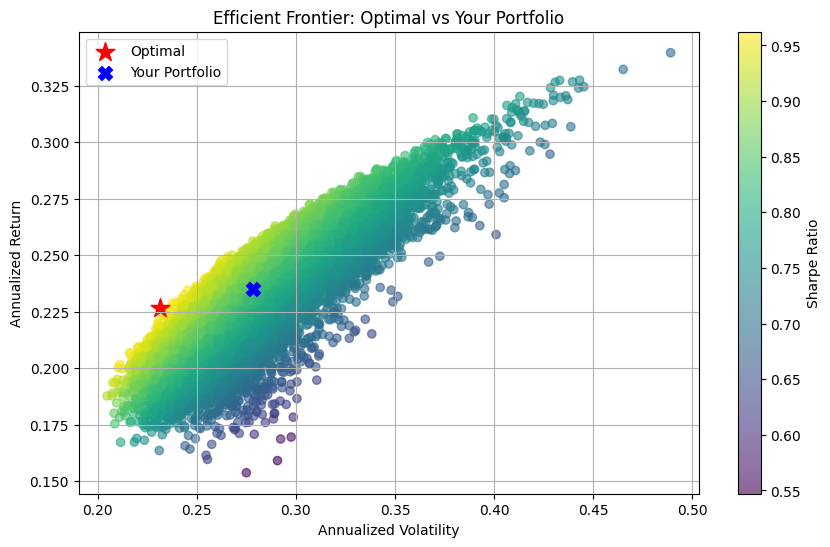

In [27]:
# Arrange user portfolio
investment_series = pd.Series(amount_invested, index=stocks)
user_weights = investment_series / investment_series.sum()
uw = user_weights.values

# Daily log-return DataFrame
returns = stocks_returns.values  # shape (T, N)

# Optimize portfolio (needs to happen before statistics comparison)
res, W, M, R = optimize_portfolio(
    returns,
    num_trading_days=252,
    num_portfolios=20000,
    seed=1,
    risk_free_rate=risk_free_rate  # <--- passed here
)

# Portfolio statistics with Rf
user_ret, user_vol, user_sharpe = portfolio_statistics(uw, returns, risk_free_rate=risk_free_rate)
opt_ret, opt_vol, opt_sharpe = portfolio_statistics(res.x, returns, risk_free_rate=risk_free_rate)

# Weights comparison table
weights_df = pd.DataFrame({
    "Your Portfolio": user_weights * 100,
    "Optimal Portfolio": res.x * 100
}, index=stocks).applymap(lambda x: f"{x:.1f}%")

show_table(weights_df)

# Performance comparison table
performance_df = pd.DataFrame({
    "Your Portfolio": [user_ret * 100, user_vol * 100, user_sharpe],
    "Optimal Portfolio": [opt_ret * 100, opt_vol * 100, opt_sharpe]
}, index=["Expected Return (%)", "Volatility (%)", "Sharpe Ratio"]).round(2)

show_table(performance_df)

# Plot efficient frontier
plt.figure(figsize=(10, 6))
sc = plt.scatter(R, M, c=M / R, cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True)

# Plot user and optimal portfolios
plt.scatter(opt_vol, opt_ret, color='red', s=200, marker='*', label='Optimal')
plt.scatter(user_vol, user_ret, color='blue', s=100, marker='X', label='Your Portfolio')

plt.legend()
plt.title("Efficient Frontier: Optimal vs Your Portfolio")
plt.show()



Even though our portfolio has a higher expected return, is also has higher risk, therefore the optimal portfolio sacrifices some return for a significant reduction in risk (Sharpe ratio of 0.81 vs 0.71)

---//---

Below we analyze both the Beta and the R^2 of both portfolios. __Beta__ is the slope of the regression (sensitivity of portfolio to the market) and __R^2__ represents the fit of the regression (what % of portfolio return variation is explained by the market variation).

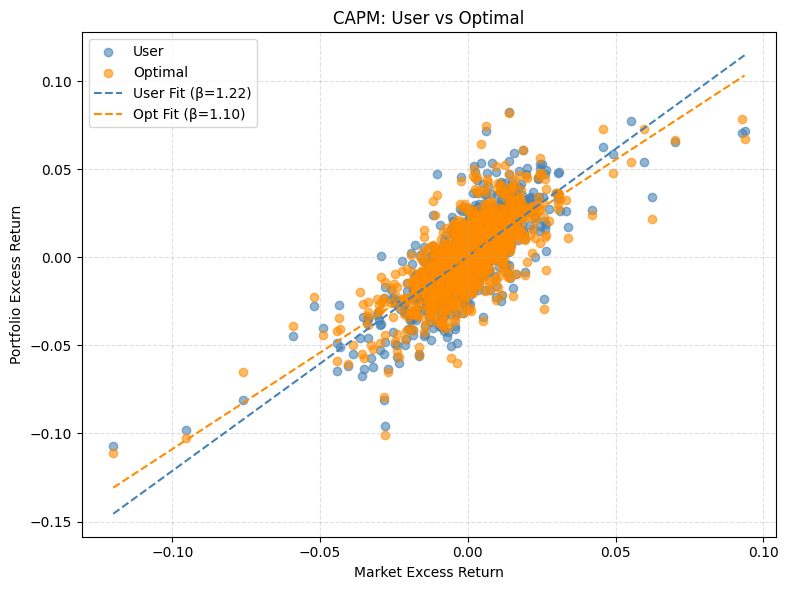

,Alpha (α),Beta (β),R²,α p-value
Your Portfolio,0.0006,1.2182,0.5887,0.0000
Optimal Portfolio,0.0006,1.0951,0.5377,0.0000


In [28]:
def capm_compare(
    prices: pd.DataFrame,
    user_weights: np.ndarray,
    opt_weights: np.ndarray,
    benchmark_ticker: str = '^GSPC',
    risk_free_rate: float = 0.0,
    num_trading_days: int = 252,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None
) -> Tuple[Tuple[float,float], Tuple[float,float]]:
    """
    Compare CAPM α, β, R² and α p-value for user vs. optimal portfolios.
    """

    # 2) Portfolio returns
    port_user = prices.dot(user_weights).pct_change().dropna().rename('user')
    port_opt  = prices.dot(opt_weights).pct_change().dropna().rename('opt')

    # 3) Market returns
    mkt = (yf.Ticker(benchmark_ticker)
             .history(start=start_date, end=end_date)['Close']
             .pct_change()
             .dropna()
             .rename('mkt')
          )

    # 4) Align dates
    df = pd.concat([mkt, port_user, port_opt], axis=1, join='inner').dropna()

    # 5) Excess returns
    rf_daily = risk_free_rate / num_trading_days
    df['mkt_ex']  = df['mkt']  - rf_daily
    df['user_ex'] = df['user'] - rf_daily
    df['opt_ex']  = df['opt']  - rf_daily

    # 6) Regression helper (returns α, β, R², p-value for intercept)
    def regress(series_name):
        x = df['mkt_ex']
        y = df[series_name]
        slope, intercept, r_val, p_val, std_err = linregress(x, y)
        alpha = intercept
        beta  = slope
        r2    = r_val**2
        # p_val here tests slope; p-value for α=0 can be approximated or obtained
        # scipy's linregress p_val tests H0: slope=0. For intercept p-value, 
        # you'd need full statsmodels; we'll use slope p-value as proxy.
        return alpha, beta, r2, p_val

    alpha_u, beta_u, r2_u, p_u = regress('user_ex')
    alpha_o, beta_o, r2_o, p_o = regress('opt_ex')

    # 7) Plot
    plt.figure(figsize=(8,6))
    plt.scatter(df['mkt_ex'], df['user_ex'],  color='steelblue',  alpha=0.6, label='User')
    plt.scatter(df['mkt_ex'], df['opt_ex'],   color='darkorange', alpha=0.6, label='Optimal')
    x0, x1 = df['mkt_ex'].min(), df['mkt_ex'].max()
    plt.plot([x0,x1], [alpha_u+beta_u*x0, alpha_u+beta_u*x1],
             color='steelblue', linestyle='--', label=f'User Fit (β={beta_u:.2f})')
    plt.plot([x0,x1], [alpha_o+beta_o*x0, alpha_o+beta_o*x1],
             color='darkorange', linestyle='--', label=f'Opt Fit (β={beta_o:.2f})')
    plt.xlabel('Market Excess Return')
    plt.ylabel('Portfolio Excess Return')
    plt.title('CAPM: User vs Optimal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # 8) Summary table
    summary = pd.DataFrame({
        'Alpha (α)':    [alpha_u,   alpha_o],
        'Beta (β)':     [beta_u,    beta_o],
        'R²':           [r2_u,      r2_o],
        'α p-value':    [p_u,       p_o]
    }, index=['Your Portfolio', 'Optimal Portfolio']).round(4)

    show_table(summary, decimals=4)
    return (alpha_u, beta_u), (alpha_o, beta_o)

# Usage
(user_alpha, user_beta), (opt_alpha, opt_beta) = capm_compare(
    prices=stocks_prices,
    user_weights=user_weights,
    opt_weights=res.x,
    benchmark_ticker=market,
    risk_free_rate=risk_free_rate,
    start_date=start_date,
    end_date=end_date
)



We can see that our initial portolio has a higher beta (1.22 vs 1.1), meaning it is more sensitive to market movements than the optimal portfolio.

In [29]:
from scipy.stats import norm
import numpy as np
import pandas as pd

def compare_var_n_days(
    prices: pd.DataFrame,
    user_weights: np.ndarray,
    opt_weights: np.ndarray,
    position: float,
    confidence: float = 0.95,
    n_days: int = 10
) -> pd.DataFrame:
    """
    Compare n-day VaR of user portfolio and optimal portfolio.

    Parameters:
        prices: DataFrame of historical prices (dates × tickers).
        user_weights: array of weights for the user portfolio.
        opt_weights: array of weights for the optimal portfolio.
        position: total monetary value invested.
        confidence: confidence level for VaR (default: 0.95).
        n_days: number of days to calculate VaR over.

    Returns:
        DataFrame comparing VaR and daily stats for both portfolios.
    """
    # Portfolio prices and returns
    port_user = prices.dot(user_weights)
    port_opt  = prices.dot(opt_weights)

    ret_user = port_user.pct_change().dropna()
    ret_opt  = port_opt.pct_change().dropna()

    # Daily mean and std
    mu_u, sigma_u = ret_user.mean(), ret_user.std()
    mu_o, sigma_o = ret_opt.mean(), ret_opt.std()

    z = norm.ppf(1 - confidence)

    # n-day VaR calculation
    var_user = position * (mu_u * n_days - sigma_u * np.sqrt(n_days) * z)
    var_opt  = position * (mu_o * n_days - sigma_o * np.sqrt(n_days) * z)

    result = pd.DataFrame({
        'Mean Return':      [mu_u, mu_o],
        'Volatility':       [sigma_u, sigma_o],
        f'{int(confidence*100)}% {n_days}-Day VaR (€)': [var_user, var_opt]
    }, index=['Your Portfolio', 'Optimal Portfolio'])

    return result.round(4)
1
var_summary_n = compare_var_n_days(
    prices=stocks_prices,
    user_weights=user_weights,
    opt_weights=res.x,
    position=investment_series.sum(),
    confidence=confidence_interval,
    n_days=n_days
)

show_table(var_summary_n, decimals=4)


,Mean Return,Volatility,95% 30-Day VaR (€)
Your Portfolio,0.0011,0.0211,2470.2496
Optimal Portfolio,0.0011,0.0199,2350.1966


Lastly, the __95% 30-Day Value at Risk (VaR)__ indicates that our initial portfolio has a higher VaR (€2470.25), meaning there is a higher potential loss at the 95% confidence level compared to the optimal portfolio (€2350.20).